In [1]:
################################################################################
######################   UsedCarPrices_CarGurus  ###############################
######################   Regression - Nonlinear  ###############################
######################  Catboost Optuna HPO GPU  ###############################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
!pip install catboost
!pip install optuna
!pip install shap
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import joblib
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

my_dpi=96

!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri May 27 00:03:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |            

In [4]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [5]:
# Set seed 
seed_value = 42
os.environ['UsedCarsCarGurus_catboostGPU'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
# Read data
df = pd.read_csv('usedCars_final.csv', low_memory=False)

In [7]:
# Set up label and features
label = df[['price']]
features = df.drop(['price'],axis=1)

In [8]:
# Set categorical variables for Catboost
categorical_features_indices = np.where(features.dtypes != np.float)[0]

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [9]:
# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        random_state=seed_value
    )
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(model, X_train, y_train,
                                      scoring='neg_root_mean_squared_error',
                                      cv=kfolds)
    rmse = np.mean(scores)
    print('- Trial RMSE:', rmse)  
    run_time = timer() - start
    
    return rmse

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_PKL


In [ ]:
################################################################################
######################     Catboost Optuna HPO  ################################
######################         300 trials       ################################
################################################################################
# Define a function for optimization of hyperparameters
def objective(trial):
    
    joblib.dump(study, 'Catboost_Optuna_300_GPU.pkl')

# Define parameter grid
    param = {
        'random_state': seed_value,
        'task_type':'GPU',
      
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.3),       
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 1e0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20), 
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),   
    }

# Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
                                                                          
      # Start timer for each trial
    model = CatBoostRegressor(
        cat_features=categorical_features_indices,
        loss_function='RMSE', 
        early_stopping_rounds=10,
        rsm=1, 
        logging_level='Silent',
        **param
    )


    return train_model_for_study(features, label, model)   


In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Catboost_Optuna_300.pkl'):
    study = joblib.load('Catboost_Optuna_300.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)
# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest RMSE', study.best_value)

Start Time           2022-05-25 17:20:41.611245
- Trial RMSE: 3566.2006285293123
- Trial RMSE: 9036.338918068212
- Trial RMSE: 9316.830163239636
- Trial RMSE: 9308.677526704745
- Trial RMSE: 2796.3240619717253
- Trial RMSE: 9524.530781780788
- Trial RMSE: 2531.48052888259
- Trial RMSE: 9513.729165473627
- Trial RMSE: 3558.3252380094177
- Trial RMSE: 4205.040177952816
- Trial RMSE: 2978.0500943794846
- Trial RMSE: 2647.543299756725
- Trial RMSE: 2717.2521703506595
- Trial RMSE: 4870.14275587516
- Trial RMSE: 2976.4711564763043
- Trial RMSE: 4892.562735999469
- Trial RMSE: 6274.153472050714
- Trial RMSE: 3155.834159644133
- Trial RMSE: 2824.192094683746
- Trial RMSE: 9533.524873039534
- Trial RMSE: 2915.0117167590574
- Trial RMSE: 2657.0151732161394
- Trial RMSE: 2628.5736391750265
- Trial RMSE: 2696.3351370068253
- Trial RMSE: 2915.12605006761
- Trial RMSE: 2716.6377969505147
- Trial RMSE: 7896.861048144191
- Trial RMSE: 2899.8530889197555
- Trial RMSE: 2667.906401038693
- Trial RMSE: 9

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'rmse'}, inplace=True)
trials_df.rename(columns={'params_bagging_temperature':'bagging_temperature'}, inplace=True)
trials_df.rename(columns={'params_boosting_type':'boosting_type'}, inplace=True)
trials_df.rename(columns={'params_bootstrap_type':'bootstrap_type'}, inplace=True)
trials_df.rename(columns={'params_depth':'depth'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg':'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf':'min_data_in_leaf'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_one_hot_max_size':'one_hot_max_size'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)
trials_df = trials_df.sort_values('rmse', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_300_GPU.csv', index=False)

     iteration         rmse             datetime_start  \
226        226  2411.989369 2022-05-26 01:59:18.309258   
225        225  2413.587562 2022-05-26 01:57:58.778205   
220        220  2414.638654 2022-05-26 01:51:24.090612   
230        230  2415.096153 2022-05-26 02:04:35.096328   
272        272  2415.099261 2022-05-26 03:04:55.072131   
..         ...          ...                        ...   
5            5  9524.530782 2022-05-25 17:29:15.958946   
177        177  9528.423947 2022-05-26 00:50:56.152153   
19          19  9533.524873 2022-05-25 17:43:49.621511   
29          29  9559.252761 2022-05-25 17:53:09.162610   
299        299          NaN 2022-05-26 03:41:45.791044   

             datetime_complete               duration  bagging_temperature  \
226 2022-05-26 02:00:37.928705 0 days 00:01:19.619447                  NaN   
225 2022-05-26 01:59:18.309053 0 days 00:01:19.530848                  NaN   
220 2022-05-26 01:52:43.148126 0 days 00:01:19.057514                

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_300_GPU.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_300_GPU.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_300_GPU.html')
fig.show()

In [10]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_PKL/

study = joblib.load('Catboost_Optuna_300_GPU.pkl')

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_PKL


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_Explanations


In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.

fig = optuna.visualization.plot_contour(study, params=['depth', 
                                                       'subsample', 
                                                       'learning_rate', 
                                                       'subsample'])
py.plot(fig, filename='contour_Catboost_Optuna_300_GPU.html')
fig.show()

In [11]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_300_GPU.csv')

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/trialOptions


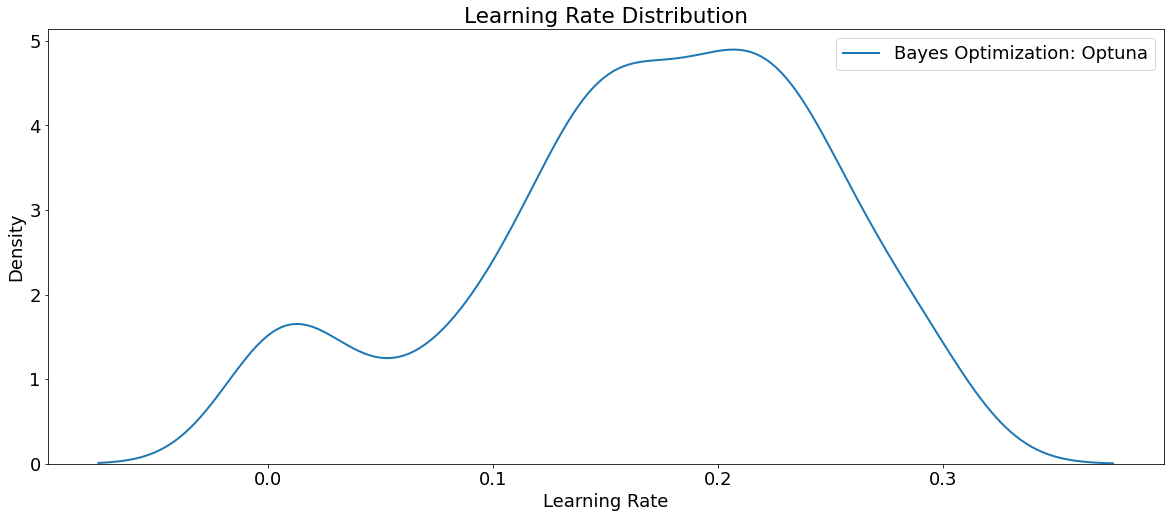

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

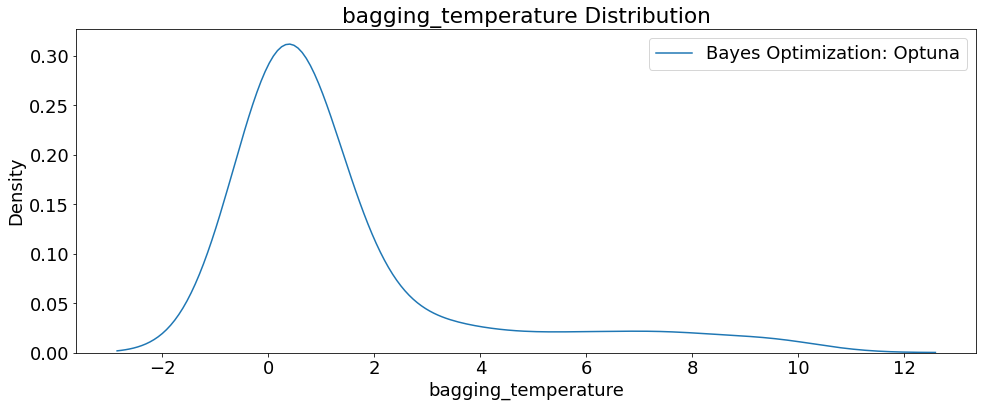

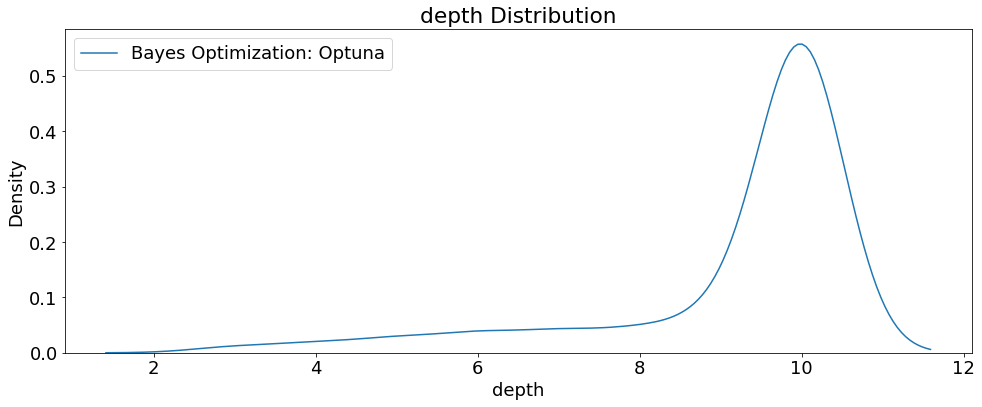

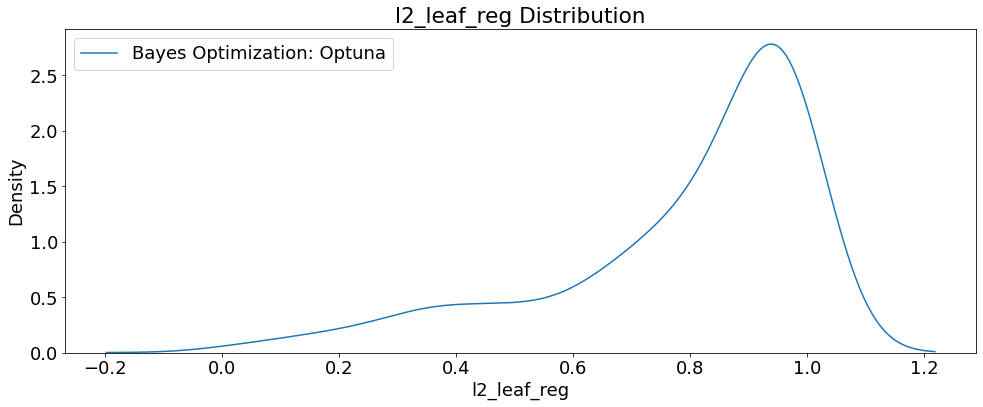

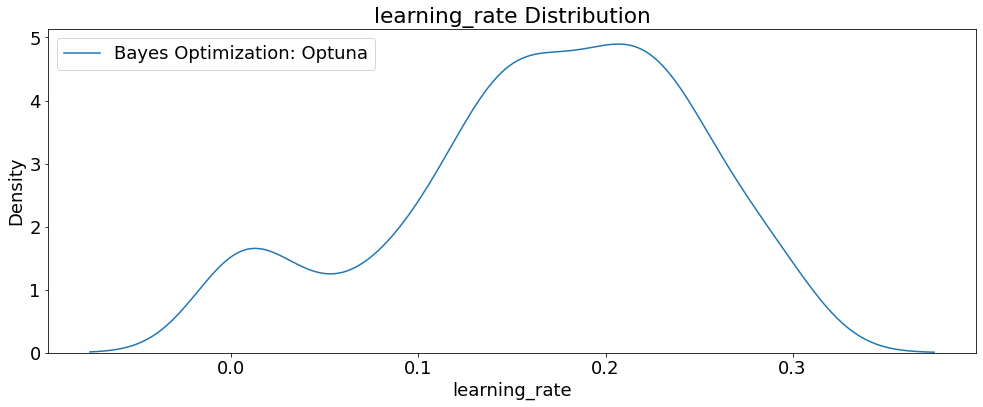

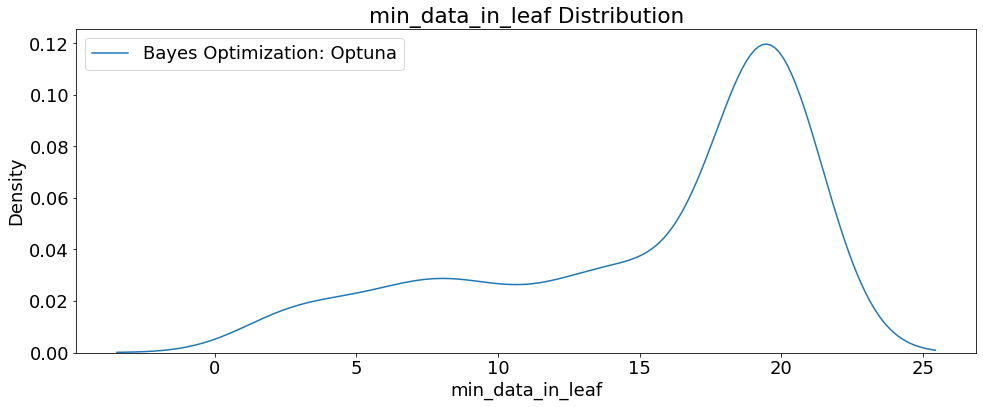

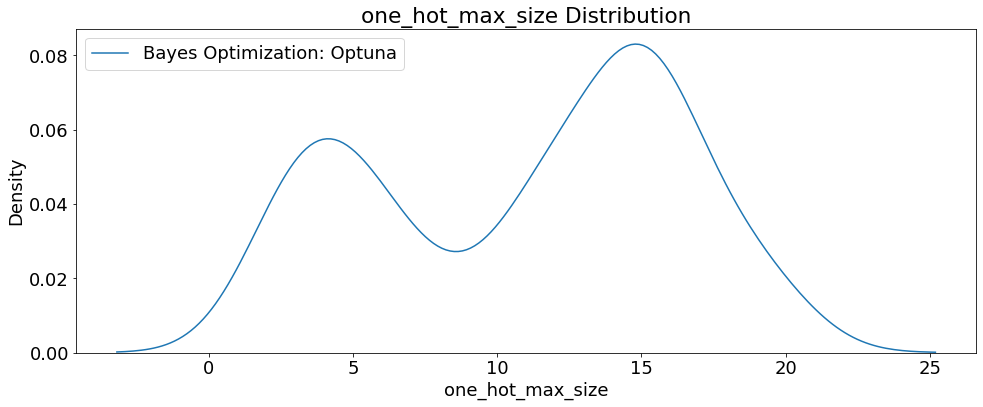

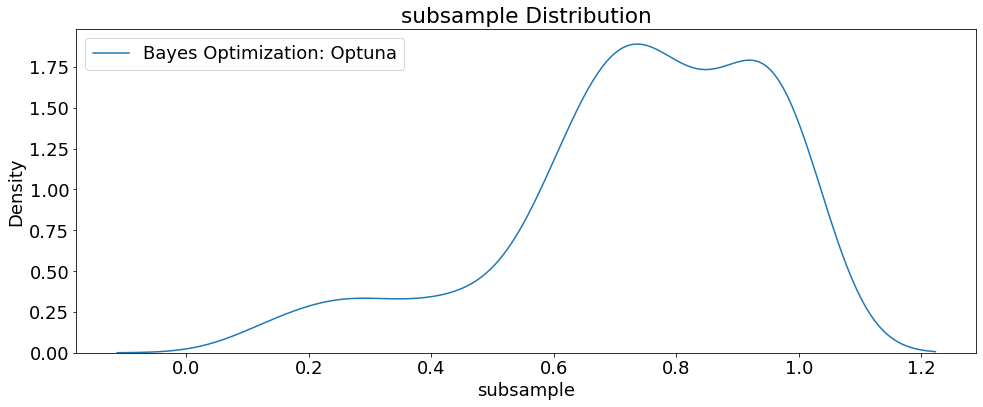

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state', 'boosting_type',
                   'bootstrap_type']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


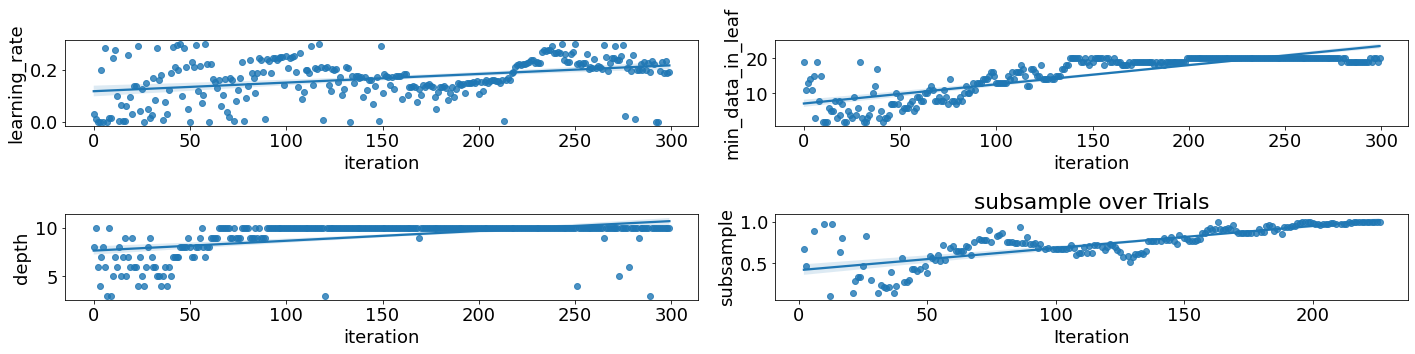

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(2, 2, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'depth', 'subsample']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()


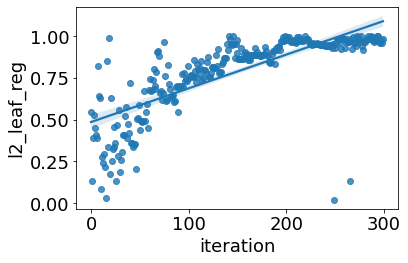

In [ ]:
# Scatterplot of regularization hyperparameters
ax = sns.regplot(x='iteration', y='l2_leaf_reg', data=trials_df)
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_PKL/

study = joblib.load('Catboost_Optuna_300_GPU.pkl')

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_PKL


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_300_GPU.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_300_GPU.html')
fig.show()

In [12]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
#params['metric'] = 'rmse'
params

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'depth': 10,
 'l2_leaf_reg': 0.9491780038684846,
 'learning_rate': 0.2317443046392417,
 'min_data_in_leaf': 20,
 'n_estimators': 481,
 'one_hot_max_size': 15,
 'random_state': 42,
 'subsample': 0.9990915161974332}

In [13]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_PKL


In [14]:
# Prepare for partitioning data
X = df.drop(['price'],axis=1)
y = df['price']

In [15]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = seed_value)

In [16]:
# Define label and features
train_label = y_train

# Remove target
train_features = X_train

# Set categorical variables for Catboost
categorical_features_indices = np.where(train_features.dtypes != np.float)[0]

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [17]:
# Re-create the best model and train on the training data
best_model = CatBoostRegressor(loss_function='RMSE', 
                               cat_features=categorical_features_indices, 
                               early_stopping_rounds=1000, 
                               rsm=1, 
                               task_type='GPU', 
                               logging_level='Silent', 
                               **params)

# Fit the model
best_model.fit(train_features, train_label)

# Save model
Pkl_Filename = 'Catboost_Optuna_trials300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_Optuna_trials300_GPU.pkl')
# print(model)
# =============================================================================

In [30]:
# Create test features
# Remove target
test_features = X_test

# Set categorical variables for Catboost
categorical_features_indices = np.where(test_features.dtypes != np.float)[0]

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [28]:
test_features = pd.get_dummies(X_test, drop_first=True)

In [19]:
print('\nModel Metrics for Catboost HPO 300 GPU trials')
y_train_pred = best_model.predict(train_features)
y_test_pred = best_model.predict(test_features)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))



Model Metrics for Catboost HPO 300 GPU trials
MAE train: 1522.476, test: 1757.100
MSE train: 4216266.861, test: 5692165.856
RMSE train: 2053.355, test: 2385.826
R^2 train: 0.954, test: 0.938


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 5692165.85642 MSE on the test set.
This was achieved using these conditions:
iteration                                     226
rmse                                  2411.989369
datetime_start         2022-05-26 01:59:18.309258
datetime_complete      2022-05-26 02:00:37.928705
duration                   0 days 00:01:19.619447
bagging_temperature                           NaN
boosting_type                               Plain
bootstrap_type                          Bernoulli
depth                                        10.0
l2_leaf_reg                              0.949178
learning_rate                            0.231744
min_data_in_leaf                             20.0
n_estimators                                481.0
one_hot_max_size                             15.0
subsample                                0.999092
state                                    COMPLETE
Name: 226, dtype: object


In [20]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Optuna/Model_Explanations


In [ ]:
# Prepare data for SHAP values
train = train_features

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(train)

<Figure size 432x288 with 0 Axes>

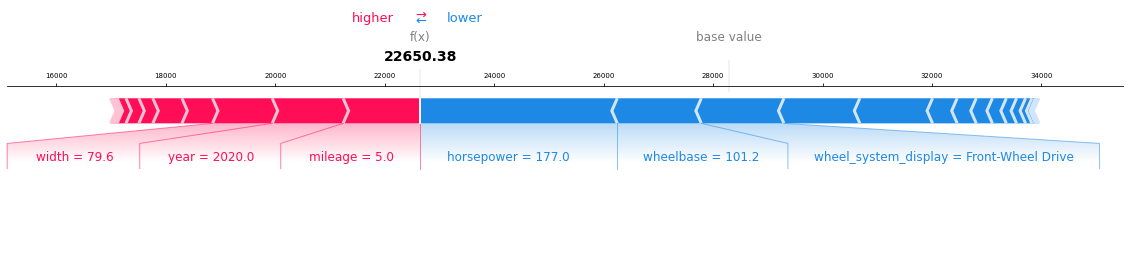

In [ ]:
# Visualize the first prediction's explanation
my_dpi=96
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], train.iloc[0,:], 
                show=False, matplotlib=True).savefig('Catboost_HPO_Optuna_300_GPU_ShapForcePlot_TrainSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

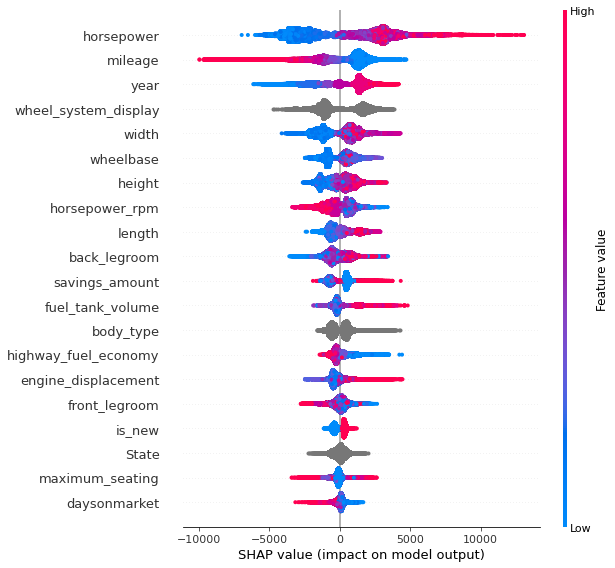

In [ ]:
# Training Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, train, show=False)
fig.savefig('Catboost_HPO_Optuna_300_GPU_ShapSummary_TrainSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(test_features)

<Figure size 432x288 with 0 Axes>

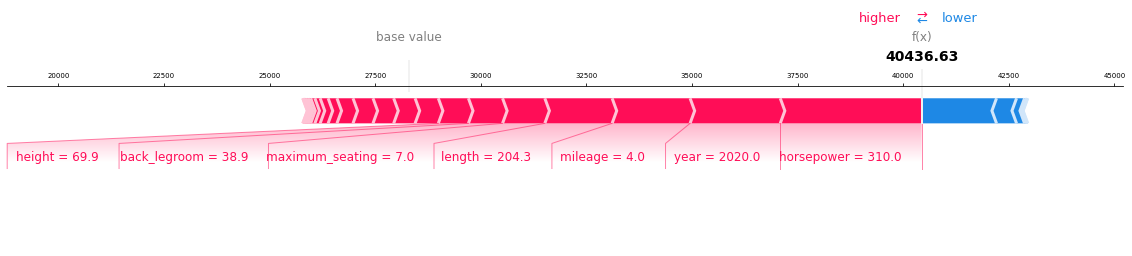

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], test_features.iloc[0,:], 
                show=False, matplotlib=True).savefig('Catboost_HPO_Optuna_300_GPU_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

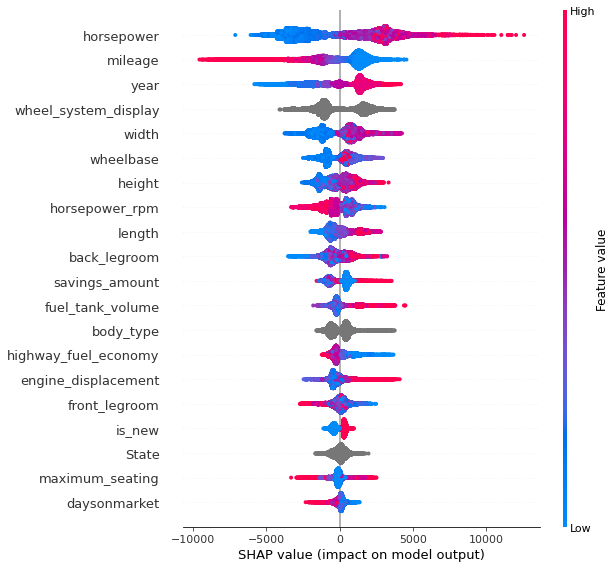

In [ ]:
# Test Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, test_features, show=False)
fig.savefig('Catboost_HPO_Optuna_300_GPU_ShapSummary_TestSet.png', dpi=my_dpi, 
            bbox_inches='tight')